In [15]:
using LinearAlgebra
using Distributions
using Random
using SparseArrays
include("../Inversion/Plot.jl")
include("../Inversion/KalmanInversion.jl")
include("Darcy-2D.jl")

forward (generic function with 1 method)

# 2D Darcy Flow

Consider the Darcy flow equation on the two-dimensional spatial domain $D=[0,1]^2$, which describes the pressure field $p(x)$ in a porous medium defined by a positive permeability field $a(x,\theta)$:

$$
\begin{align*}
    -\nabla \cdot (a(x, \theta) \nabla p(x)) &= f(x), \quad &&x\in D,\\
    p(x) &= 0, \quad &&x\in \partial D.
\end{align*}
$$

For simplicity, Dirichlet boundary conditions on the pressure are applied on $\partial D$. The fluid source field $f$ is defined as

$$
\begin{align*}
    f(x_1, x_2) = \begin{cases}
               1000 & 0 \leq x_2 \leq \frac{4}{6}\\
               2000 & \frac{4}{6} < x_2 \leq \frac{5}{6}\\
               3000 & \frac{5}{6} < x_2 \leq 1\\
            \end{cases}. 
\end{align*}
$$



The equation is solved by the finite difference method similar with the [one-dimensional Darcy flow problem](../Posterior/Darcy-1D.ipynb), where computational domain is discretized by a $N \times N$ uniform grid ($N=80$ for the present study).


## Random log-Gaussian Field

Assuming that $\log a(x, \theta)$ is a centred Gaussian with covariance 
$$\mathsf{C} = (-\Delta + \tau^2 )^{-d};$$
here $-\Delta$ denotes the Laplacian on $D$ subject to homogeneous Neumann boundary conditions on the space of spatial-mean zero functions, 
$\tau > 0$ denotes the inverse length scale of the random field and $d  > 0$ determines its regularity.
The Gaussian field can be represented by the Karhunen–Loève (KL) expansion

\begin{equation}
\label{eq:KL-2d}
    \log a(x,\theta) = \sum_{l\in K} \theta_{(l)}\sqrt{\lambda_l} \psi_l(x),
\end{equation}
where $K = \mathcal{Z}^{0+}\times\mathcal{Z}^{0+} \setminus \{0,0\}$, and the eigenpairs are of the form

$$
\begin{equation*}
    \psi_l(x) = \begin{cases}
                 \sqrt{2}\cos(\pi l_1 x_1)              & l_2 = 0\\
                 \sqrt{2}\cos(\pi l_2 x_2)              & l_1 = 0\\
                 2\cos(\pi l_1 x_1)\cos(\pi l_2 x_2)    & \textrm{otherwise}\\
                 \end{cases},
                 \qquad \lambda_l = (\pi^2 |l|^2 + \tau^2)^{-d}
\end{equation*}
$$

and $\theta_{(l)} \sim \mathcal{N}(0,1)$ i.i.d. The KL expansion can be rewritten as a sum over $\mathcal{Z}^{0+}$ rather than a lattice: 

$$
\begin{equation}
\label{eq:KL-1d}
    \log a(x,\theta) = \sum_{k\in \mathcal{Z}^{0+}} \theta_{(k)}\sqrt{\lambda_k} \psi_k(x),
\end{equation}
$$

where the eigenvalues $\lambda_k$ are in descending order.
In practice, we truncate this sum to $N_\theta$ terms, based on the
largest $N_\theta$ eigenvalues, and hence $\theta\in\mathcal{R}^{N_\theta}$.
 


## Inverse Problem Setup

For the inverse problem, we recover the log-permeability field $\log a_{{ref}}(x)$ from the observation 
$y_{ref}$, which consists of pointwise measurements of the 
pressure value $p(x)$ at $49$ equidistant points in the domain. 


We generate a truth random field $\log a_{{ref}}(x)$ with $\theta \sim \mathcal{N}(0, I)$ in $\mathcal{R}^{256}$ 
(i.e. we use the first $256$ KL modes) to construct the observation $y_{obs}$.

$5\%$ Gaussian random noises are added to make data $y_{obs}$:

$$
\begin{equation}
    y_{obs} = y_{ref} + \epsilon \odot  \mathcal{N}(0, I),
\end{equation}
$$

where $\epsilon = 5\% y_{ref}$, and $\odot$ denotes element-wise multiplication.



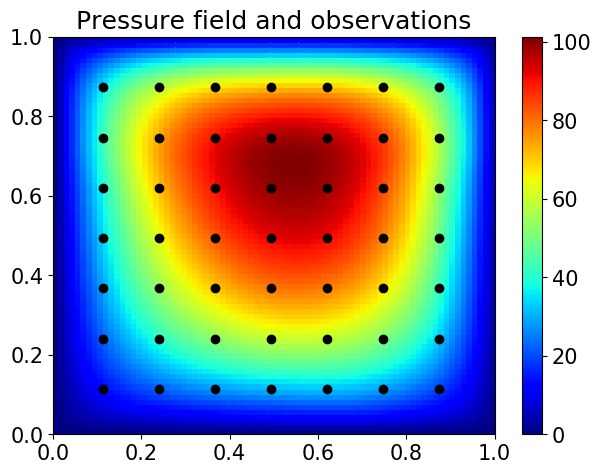

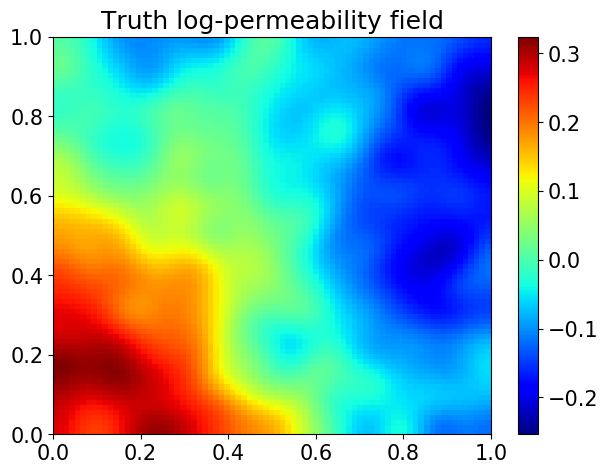

PyObject Text(0.5, 1, 'Truth log-permeability field')

In [24]:
N, L = 80, 1.0
obs_ΔN = 10
d = 2.0
τ = 3.0
N_KL = 256
N_θ = 0
darcy = Setup_Param(N, L, N_KL, obs_ΔN, N_θ, d, τ)

κ_2d = exp.(darcy.logκ_2d)
h_2d = solve_Darcy_2D(darcy, κ_2d)
y_noiseless = compute_obs(darcy, h_2d)

figure(1)
plot_field(darcy, h_2d, true)
PyPlot.title("Pressure field and observations")
figure(2)
plot_field(darcy, darcy.logκ_2d, false)
PyPlot.title("Truth log-permeability field")
    

## Inverse Problem Setup

Using this data, we consider two incomplete parameterization scenarios:  
* solving for the first $32$ KL modes ($N_\theta=32$) 
* solving for the first $8$ KL modes ($N_\theta=8$).  
        
        
UKI is applied and initialized with $\theta_0 \sim \mathcal{N}(0,  I)$. 
The observation error is estimated to be $\eta \sim \mathcal{N}(0, I)$. 

### $N_\theta = 32$ Case
For the $N_\theta = 32$ case, the convergence of the log-permeability fields $\log a(x, m_n)$ and the optimization errors at each iteration for different noise levels are depicted; 
Without explicit regularization ($\alpha=1.0$), UKI suffers from overfitting for noisy scenarios: the optimization errors keep decreasing, but the parameter errors show the ``U-shape'' characteristic of overfitting. Adding regularization ($\alpha=0.5$) relieves the overfitting.

The estimated log-permeability fields $\log a(x,m_n)$ at the 20th iteration and the truth random field are depicted.  The estimated log-permeability field obtained by regularized UKI captures main features of the truth random field.



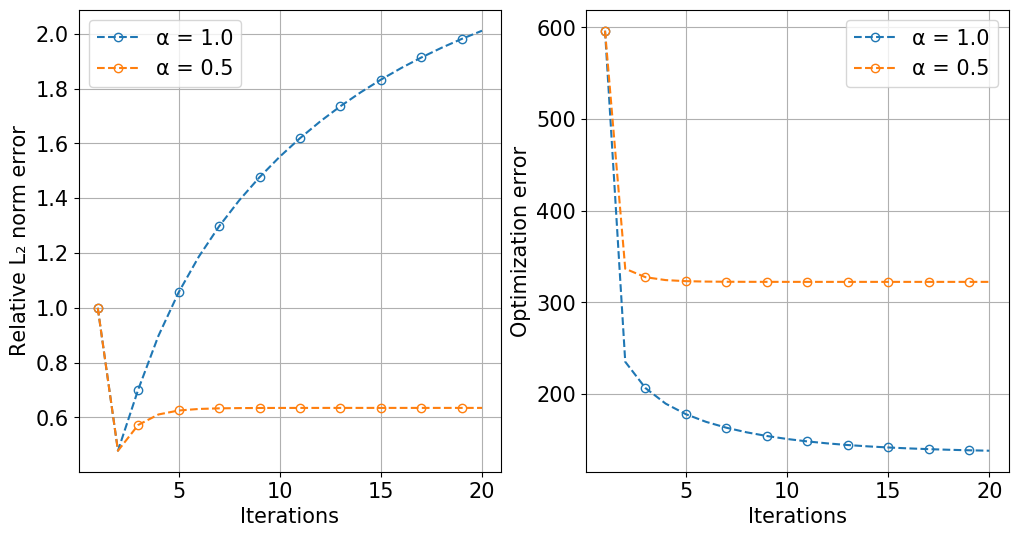

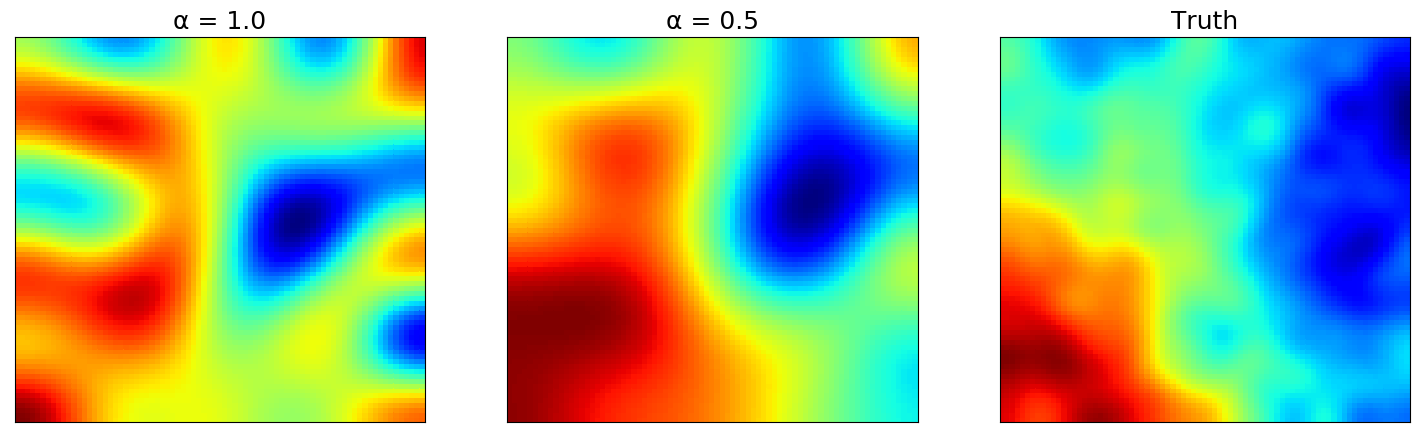

In [54]:
# N_θ = 32 case with 5% Gaussian error
N_θ = darcy.N_θ = 32
noise_level = 0.05

# observation
y = copy(y_noiseless)
Random.seed!(123);
for i = 1:length(y)
    noise = rand(Normal(0, noise_level*y[i]))
    y[i] += noise
end
Σ_η = Array(Diagonal(fill(1.0, length(y))))

# initial mean and covariance
θ0_mean = zeros(Float64, N_θ)  # mean 
θθ0_cov = Array(Diagonal(fill(1.0, N_θ)))

update_freq = 0
N_iter = 20



# visulize the error
fig, ax = PyPlot.subplots(ncols = 2, sharex=true, sharey=false, figsize=(12,6))


# visulize the log permeability field
fig_logk, ax_logk = PyPlot.subplots(ncols = 3, sharex=true, sharey=true, figsize=(18,5))
for ax in ax_logk ;  ax.set_xticks([]) ; ax.set_yticks([]) ; end
color_lim = (minimum(darcy.logκ_2d), maximum(darcy.logκ_2d))
plot_field(darcy, darcy.logκ_2d, color_lim, ax_logk[3]) 
ax_logk[3].set_title("Truth")

ites = Array(1:N_iter)
α_regs = [1.0; 0.5]
for test_id = 1:2
    α_reg = α_regs[test_id]
    
    ukiobj = UKI_Run(darcy,  forward, θ0_mean, θθ0_cov, y, Σ_η, α_reg, update_freq, N_iter)

    errors = zeros(Float64, (2, N_iter))
    for i = 1:N_iter
        errors[1, i] = norm(darcy.logκ_2d - compute_logκ_2d(darcy, ukiobj.θ_mean[i]))/norm(darcy.logκ_2d)
        errors[2, i] = 0.5*(ukiobj.y_pred[i] - ukiobj.y)'*(ukiobj.Σ_η\(ukiobj.y_pred[i] - ukiobj.y)) 
    end
    
    ax[1].plot(ites, errors[1, :], linestyle="--", marker="o", fillstyle="none", markevery=2, label= "α = $(α_reg)")
    ax[1].set_ylabel("Relative L₂ norm error")
    ax[1].set_xlabel("Iterations")
    ax[1].grid(true)
    ax[1].legend()
        
        
    ax[2].plot(ites, errors[2, :], linestyle="--", marker="o", fillstyle="none", markevery=2, label= "α = $(α_reg)")
    ax[2].set_xlabel("Iterations")
    ax[2].set_ylabel("Optimization error")
    ax[2].grid(true)
    ax[2].legend()
    
    plot_field(darcy, compute_logκ_2d(darcy, ukiobj.θ_mean[end]), color_lim, ax_logk[test_id]) 
    ax_logk[test_id].set_title("α = $(α_reg)")
end



### $N_\theta = 8$ Case

For $N_\theta = 8$ case, the convergence of the log-permeability fields $\log a(x, m_n)$ and the optimization errors at each iteration for different noise levels are depicted. 
Even without explicit regularization~($\alpha=1.0$), UKI does not suffer from overfitting. 
The estimated log-permeability fields $\log a(x,m_n)$ at the 20th iteration for different noise levels, obtained by the UKI and the truth random field, are depicted. 
Comparing with the $N_\theta = 32$ case, UKI with $N_{\theta} = 8$ performs better for the $5\%$ noise scenario. This indicates the possibility of regularizing the inverse problem by reducing the parameter dimensionality.


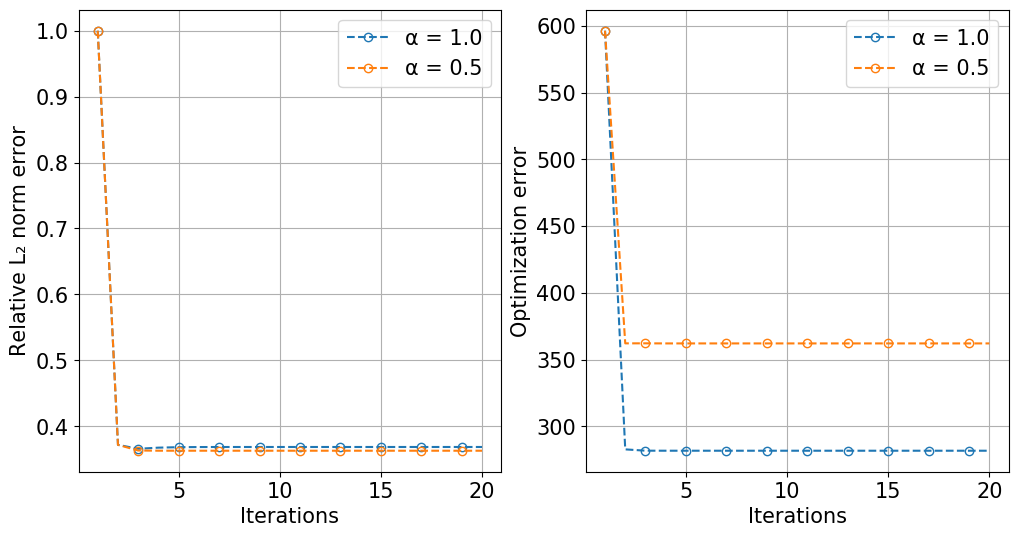

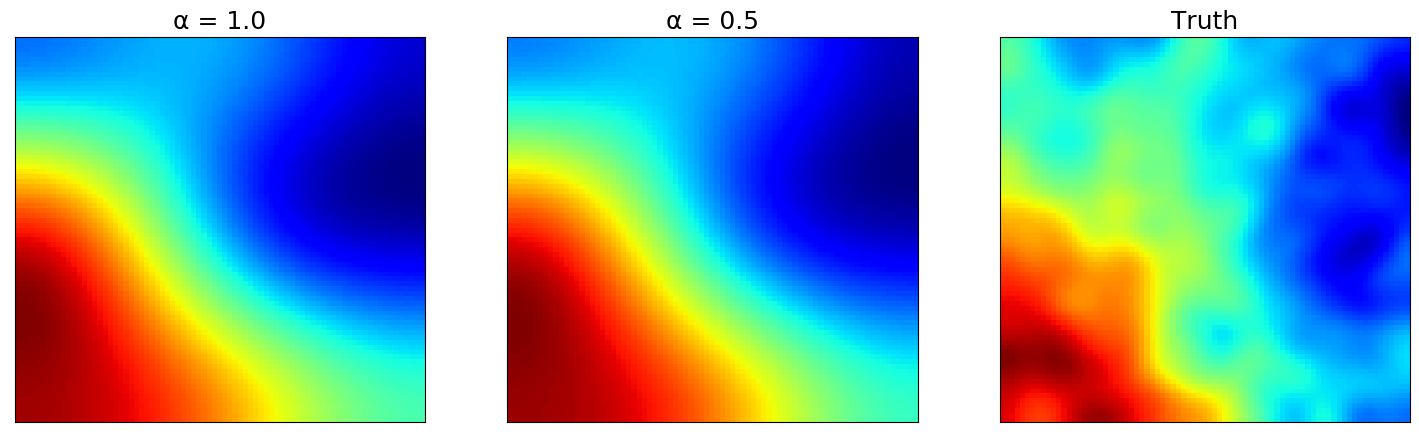

In [53]:
# N_θ = 8 case with 5% Gaussian error
N_θ = darcy.N_θ = 8
noise_level = 0.05

# observation
y = copy(y_noiseless)
Random.seed!(123);
for i = 1:length(y)
    noise = rand(Normal(0, noise_level*y[i]))
    y[i] += noise
end
Σ_η = Array(Diagonal(fill(1.0, length(y))))

# initial mean and covariance
θ0_mean = zeros(Float64, N_θ)  # mean 
θθ0_cov = Array(Diagonal(fill(1.0, N_θ)))

update_freq = 0
N_iter = 20


# visulize the error
fig, ax = PyPlot.subplots(ncols = 2, sharex=true, sharey=false, figsize=(12,6))


# visulize the log permeability field
fig_logk, ax_logk = PyPlot.subplots(ncols = 3, sharex=true, sharey=true, figsize=(18,5))
for ax in ax_logk ;  ax.set_xticks([]) ; ax.set_yticks([]) ; end
color_lim = (minimum(darcy.logκ_2d), maximum(darcy.logκ_2d))
plot_field(darcy, darcy.logκ_2d, color_lim, ax_logk[3]) 
ax_logk[3].set_title("Truth")


ites = Array(1:N_iter)
α_regs = [1.0; 0.5]
for test_id = 1:2
    α_reg = α_regs[test_id]
    
    ukiobj = UKI_Run(darcy,  forward, θ0_mean, θθ0_cov, y, Σ_η, α_reg, update_freq, N_iter)

    errors = zeros(Float64, (2, N_iter))
    for i = 1:N_iter
        errors[1, i] = norm(darcy.logκ_2d - compute_logκ_2d(darcy, ukiobj.θ_mean[i]))/norm(darcy.logκ_2d)
        errors[2, i] = 0.5*(ukiobj.y_pred[i] - ukiobj.y)'*(ukiobj.Σ_η\(ukiobj.y_pred[i] - ukiobj.y)) 
    end
    
    ax[1].plot(ites, errors[1, :], linestyle="--", marker="o", fillstyle="none", markevery=2, label= "α = $(α_reg)")
    ax[1].set_ylabel("Relative L₂ norm error")
    ax[1].set_xlabel("Iterations")
    ax[1].grid(true)
    ax[1].legend()
        
        
    ax[2].plot(ites, errors[2, :], linestyle="--", marker="o", fillstyle="none", markevery=2, label= "α = $(α_reg)")
    ax[2].set_xlabel("Iterations")
    ax[2].set_ylabel("Optimization error")
    ax[2].grid(true)
    ax[2].legend()
    
    plot_field(darcy, compute_logκ_2d(darcy, ukiobj.θ_mean[end]), color_lim, ax_logk[test_id]) 
    ax_logk[test_id].set_title("α = $(α_reg)")
end